### Intramarket differencing
Research
ref: https://github.com/neurotrader888/IntramarketDifference/blob/main/intermarket.py

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import os
import scipy
import mplfinance as mpf

/tmp/nix-shell.X7MVnl/ipykernel_3654/4154764456.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades

In [3]:
def cmma(ohlc: pd.DataFrame, lookback: int, atr_lookback: int = 168):
    # cmma = Close minus moving average
    atr = ta.atr(ohlc['high'], ohlc['low'], ohlc['close'], atr_lookback)
    ma = ohlc['close'].rolling(lookback).mean()
    ind = (ohlc['close'] - ma) / (atr * lookback ** 0.5)
    return ind

def threshold_revert_signal(ind: pd.Series, threshold: float):
    # Outputs a 1 or -1 signal once the indicator goes above threshold or below -threshold
    # Outputs 0 again once the indicator returns to 0

    signal = np.zeros(len(ind))
    position = 0
    for i in range(len(ind)):
        if ind[i] > threshold:
            position = 1
        if ind[i] < -threshold:
            position = -1

        if position == 1 and ind[i] <= 0:
            position = 0
        
        if position == -1 and ind[i] >= 0:
            position = 0

        signal[i] = position
    
    return signal

In [4]:
def import_csv_files(file_path: str):
    df = pd.read_csv(file_path)
    return df


In [5]:
# Format Data
btc_data = import_csv_files("BTCUSDT3600.csv")
btc_data['date'] = btc_data['date'].astype('datetime64[s]')
btc_data = btc_data.set_index('date')
btc_data = btc_data.dropna()


eth_data = import_csv_files("ETHUSDT3600.csv")
eth_data['date'] = eth_data['date'].astype('datetime64[s]')
eth_data = eth_data.set_index('date')
eth_data = eth_data.dropna()


In [6]:
# Get log diff of eth and btc
eth_data['diff'] = np.log(eth_data['close']).diff()
btc_data['diff'] = np.log(btc_data['close']).diff()

eth_data['next_return'] = eth_data['diff'].shift(-1)
btc_data['next_return'] = btc_data['diff'].shift(-1)


Text(0, 0.5, 'Values')

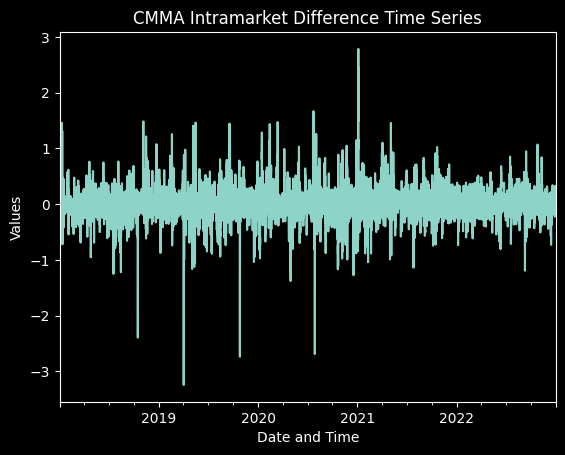

In [17]:
# CMMA Intramarket Diff
lookback = 24
threshold = 0.25
atr_lookback = 168
btc_cmma = cmma(btc_data, lookback, atr_lookback)
eth_cmma = cmma(eth_data, lookback, atr_lookback)
intermarket_diff = eth_cmma - btc_cmma

# Plot of timeseries for cmma intramarket diff
plt.style.use('dark_background')  # Set the plot background to black

intermarket_diff.plot()
plt.title('CMMA Intramarket Difference Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')

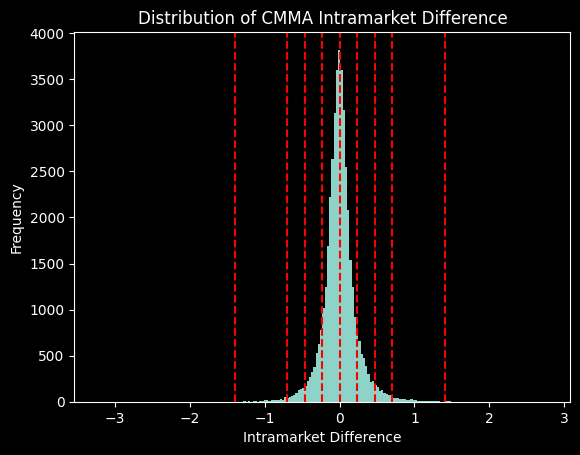

In [48]:
#plot distribution of cmma intramarket diff
plt.hist(intermarket_diff, bins=200)
plt.title('Distribution of CMMA Intramarket Difference')
plt.xlabel('Intramarket Difference')
plt.ylabel('Frequency')

# Plot vertical lines for important standard deviations
std_devs = [-6, -3, -2, 0, -1, 1, 2, 3, 6]  # Modify this list as per your requirements
for std_dev in std_devs:
    plt.axvline(std_dev * intermarket_diff.std(), color='r', linestyle='--')

plt.show()


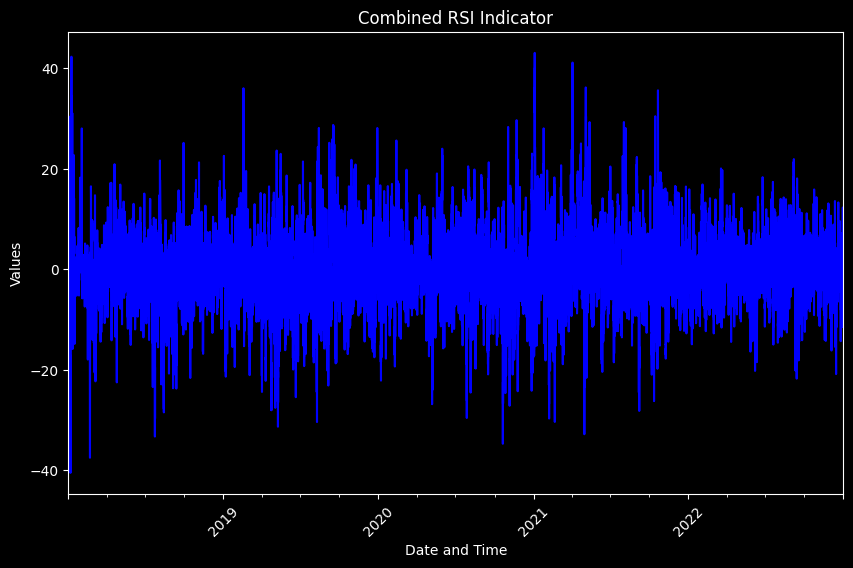

In [19]:
# rsi intramarket diff
btc_rsi = ta.rsi(btc_data['close'])
eth_rsi = ta.rsi(eth_data['close'])
intermarket_diff_rsi = eth_rsi - btc_rsi

time_series = intermarket_diff_rsi
time_series.index = pd.to_datetime(time_series.index)

# Plotting the time series
fig, ax = plt.subplots(figsize=(10, 6))
time_series.plot(ax=ax, color='b')

plt.title('Combined RSI Indicator')
plt.xlabel('Date and Time')
plt.ylabel('Values')

plt.xticks(rotation=45)
plt.show()


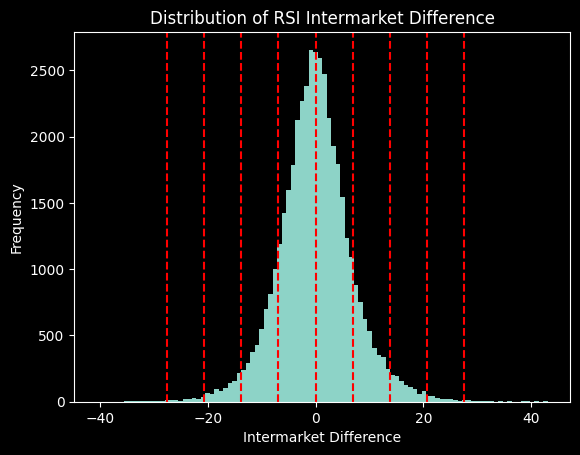

In [38]:
# plot distribution of rsi intramarket diff
plt.hist(intermarket_diff_rsi, bins=100)
plt.title('Distribution of RSI Intermarket Difference')
plt.xlabel('Intermarket Difference')
plt.ylabel('Frequency')
# Plot vertical lines for important standard deviations
std_devs = [-4,-3,-2, -1, 0, 1, 2, 3, 4]  # Modify this list as per your requirements
for std_dev in std_devs:
    plt.axvline(std_dev * intermarket_diff_rsi.std(), color='r', linestyle='--')

plt.show()


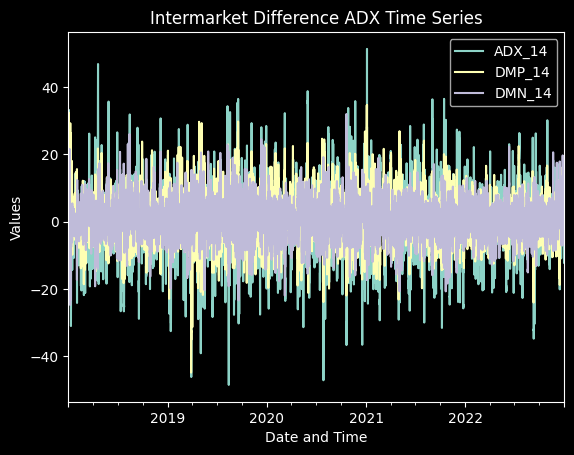

In [27]:
eth_adx = ta.adx(eth_data['high'], eth_data['low'], eth_data['close'])
btc_adx = ta.adx(btc_data['high'], btc_data['low'], btc_data['close'])
intermarket_diff_adx = eth_adx - btc_adx

intermarket_diff_adx.plot()
plt.title('Intermarket Difference ADX Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()


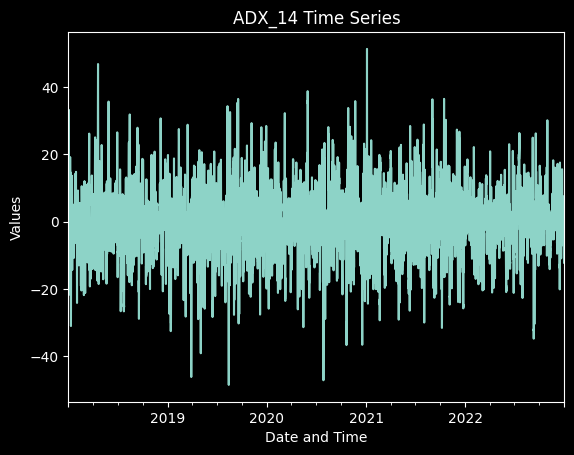

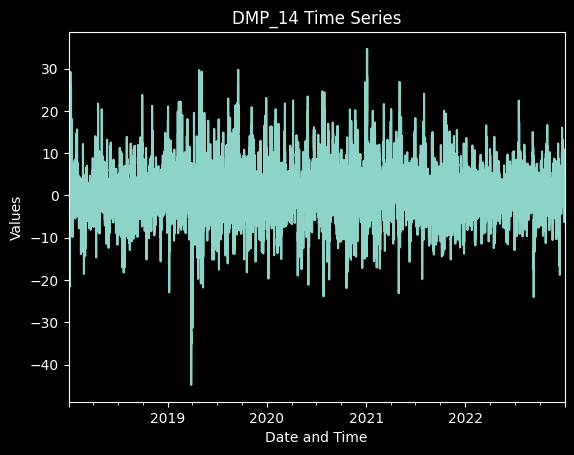

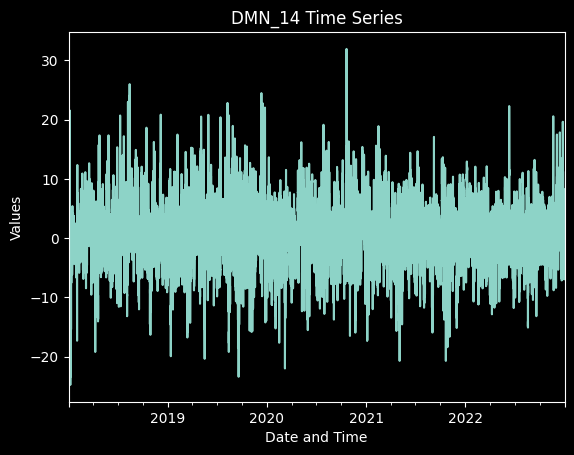

In [35]:

# Plot ADX_14
intermarket_diff_adx['ADX_14'].plot()
plt.title('ADX_14 Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()

# Plot DMP_14
intermarket_diff_adx['DMP_14'].plot()
plt.title('DMP_14 Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()

# Plot DMN_14
intermarket_diff_adx['DMN_14'].plot()
plt.title('DMN_14 Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()


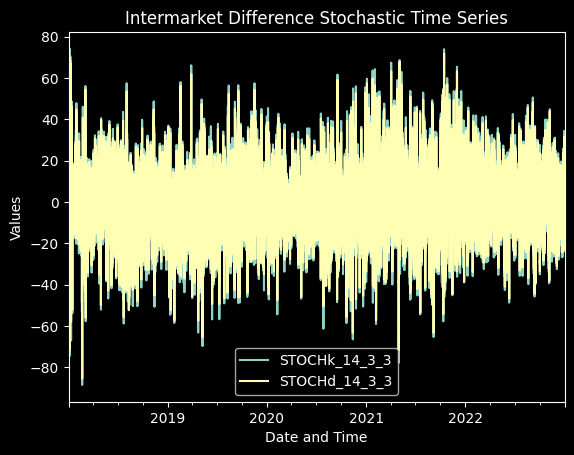

In [28]:
btc_stoch = ta.stoch(btc_data['high'], btc_data['low'], btc_data['close'])
eth_stoch = ta.stoch(eth_data['high'], eth_data['low'], eth_data['close'])
intermarket_diff_stc = eth_stoch - btc_stoch
import matplotlib.pyplot as plt

intermarket_diff_stc.plot()
plt.title('Intermarket Difference Stochastic Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()


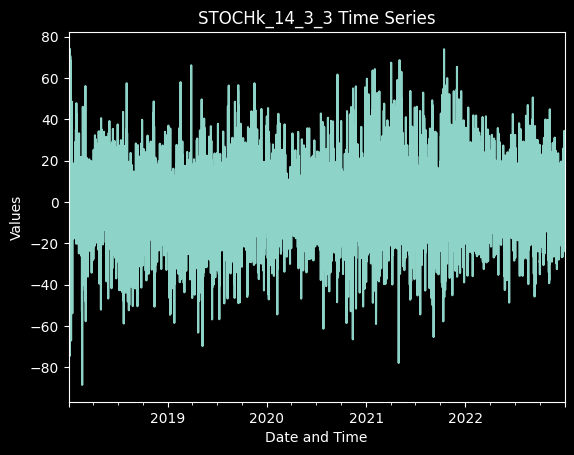

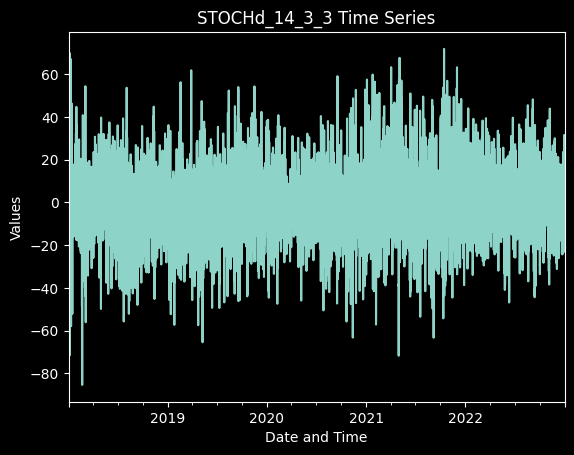

In [37]:
# Plot STOCHk_14_3_3 timeseries
intermarket_diff_stc['STOCHk_14_3_3'].plot()
plt.title('STOCHk_14_3_3 Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()

# Plot STOCHd_14_3_3 timeseries
intermarket_diff_stc['STOCHd_14_3_3'].plot()
plt.title('STOCHd_14_3_3 Time Series')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.show()


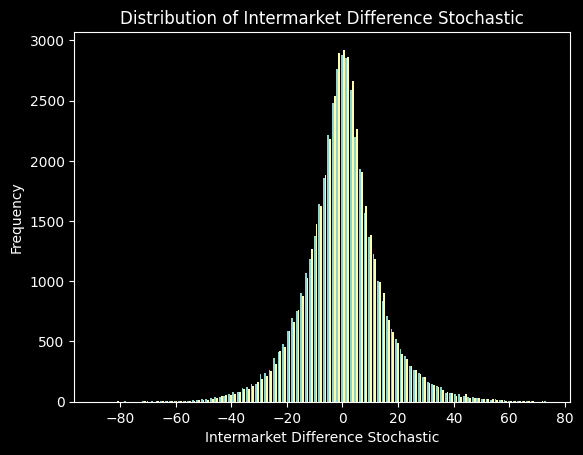

In [31]:
plt.hist(intermarket_diff_stc, bins=100)
plt.title('Distribution of Intermarket Difference Stochastic')
plt.xlabel('Intermarket Difference Stochastic')
plt.ylabel('Frequency')
plt.show()


In [ ]:


eth_data['sig'] = threshold_revert_signal(intermarket_diff, threshold)
rets = eth_data['sig'] * eth_data['next_return']
long_trades, short_trades, all_trades = get_trades_from_signal(eth_data, eth_data['sig'])
plt.style.use('dark_background')
rets = eth_data['sig'] * eth_data['next_return']
pf = rets[rets > 0].sum() / rets[rets<0].abs().sum()
print("Profit factor", pf)
rets.cumsum().plot()
plt.ylabel("Cumulative Log Return")


<Axes: xlabel='date'>

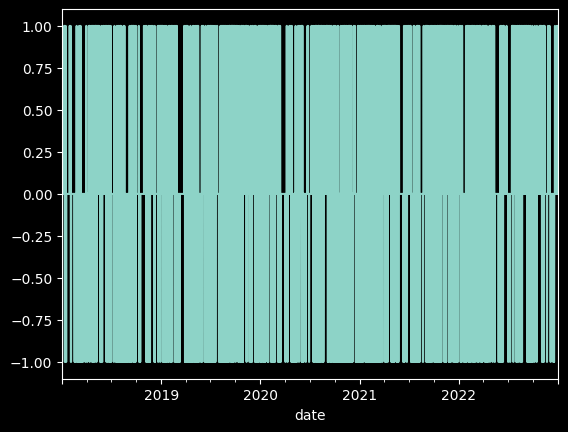

In [9]:
# Plot Signals
eth_data['sig']
eth_data['sig'].plot()


In [10]:
# Plot Returns

In [11]:
long_tr = long_trades['return']
short_tr = short_trades['return']

In [12]:
# Print Statistics
print("long trades")
print("# of trades", len(long_tr))
print("win rate", len(long_tr[long_tr > 0]) / len(long_tr) )
print("avg trade %", long_tr.mean() * 100)
print("") 
print("short trades")
print("# of trades", len(short_tr))
print("win rate", len(short_tr[short_tr > 0]) / len(short_tr) )
print("avg trade %", short_tr.mean() * 100)
average_return = rets.mean()
std_dev = rets.std()
sharpe_ratio = average_return / std_dev
sharpe_ratio


long trades
# of trades 388
win rate 0.5128865979381443
avg trade % 0.5819315538027854

short trades
# of trades 372
win rate 0.5188172043010753
avg trade % 0.6888949981048935


0.015194708399426576

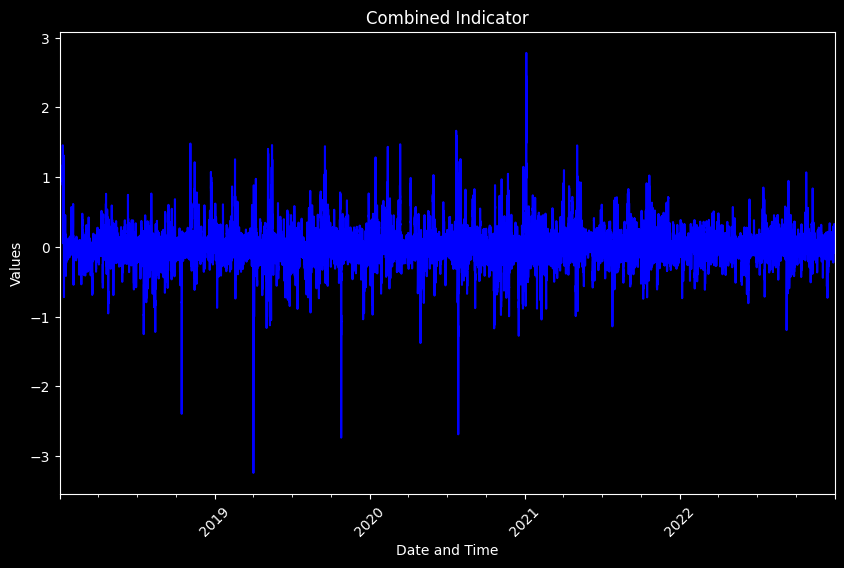